**CNN Model**

In [ ]:
# Standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch and torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets, models

# Hugging Face Transformers
from transformers import ViTForImageClassification, ViTFeatureExtractor

# Custom project imports
from src.dataset_loader import ImageDataset  # Custom dataset class that reads from a CSV
import config  # Configuration file with paths and class names

In [ ]:
# 1. CNN Model: ResNet-18
class CNNModel_ResNet18(nn.Module):
    def __init__(self):
        super(CNNModel_ResNet18, self).__init__()
        # Load a pre-trained ResNet-18 model from torchvision
        self.model = models.resnet18(pretrained=True)
        # Replace the final fully connected layer to output 2 classes (binary classification)
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)

    def forward(self, x):
        # Define the forward pass using the modified ResNet-18 model
        return self.model(x)

# Instantiate the ResNet-18 model for binary classification
model = CNNModel_ResNet18()

# Load the trained weights from a saved model file
model.load_state_dict(torch.load('cnn_resnet18_model.pth'))

# Set the model to evaluation mode (disables dropout, batchnorm updates, etc.)
model.eval()


CNNModel_ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
# 1. Define image transformations

# These transformations will be applied to training images for data augmentation
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224 pixels
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally (augmentation)
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly adjust brightness and contrast
    transforms.ToTensor(),  # Convert PIL Image to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  # Normalize pixel values to [-1, 1]
                         std=[0.5, 0.5, 0.5])
])

# These transformations will be applied to test images (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match input size expected by the model
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  # Normalize pixel values
                         std=[0.5, 0.5, 0.5])
])

# 2. Load the dataset from a CSV file

# This dataset reads image file paths and labels from a CSV file
# encode=True converts string labels (e.g. "real", "cartoon") to integers (0, 1)
full_dataset = ImageDataset(csv_file=config.CSV_PATH, transform=None, encode=True)

# 3. Split the dataset into training and testing sets
# Use 80% of the data for training and 20% for testing
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# random_split creates two subsets of the dataset
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# '. Assign transforms to each split

# Apply training transformations only to the training set
train_dataset.dataset.transform = transform_train

# Apply testing transformations only to the test set
test_dataset.dataset.transform = transform_test

# 5. Create PyTorch DataLoaders

# DataLoaders batch the data and optionally shuffle it
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Shuffle for training
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No shuffle for testing


Accuracy: 0.9833
              precision    recall  f1-score   support

        Real       1.00      0.96      0.98        25
     Cartoon       0.97      1.00      0.99        35

    accuracy                           0.98        60
   macro avg       0.99      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



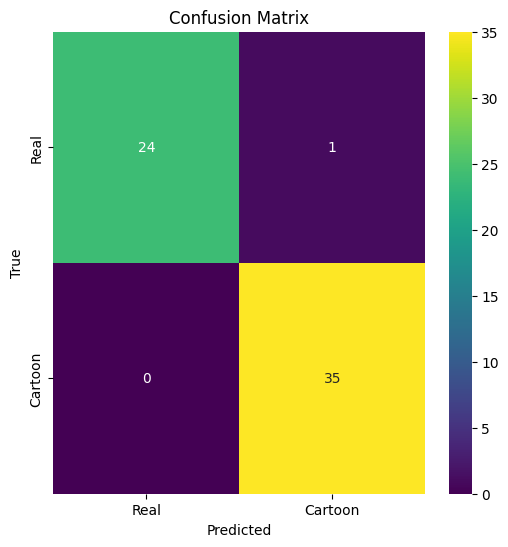

In [ ]:
# Initialize variables to store metrics
all_labels = []         # Will hold all true labels
all_predictions = []    # Will hold all predicted labels

# Evaluation loop
with torch.no_grad():  # Disable gradient computation to save memory during evaluation
    for images, labels in test_loader:
        outputs = model(images)                    # Forward pass: get model outputs
        _, predicted = torch.max(outputs, 1)       # Get the predicted class with the highest score

        all_labels.extend(labels.cpu().numpy())        # Store true labels (moved to CPU and converted to numpy)
        all_predictions.extend(predicted.cpu().numpy())# Store predicted labels

# Compute accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f'Accuracy: {accuracy:.4f}')  # Print accuracy score rounded to 4 decimal places

# Compute classification report: includes precision, recall, and F1-score
report = classification_report(all_labels, all_predictions, target_names=['Real', 'Cartoon'])
print(report)  # Display the classification report

# Display the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(6, 6))  # Set figure size for the confusion matrix
sns.heatmap(
    cm, annot=True, fmt='d', cmap='viridis',
    xticklabels=['Real', 'Cartoon'], yticklabels=['Real', 'Cartoon']
)  # Plot confusion matrix as a heatmap
plt.xlabel('Predicted')     # Label for x-axis
plt.ylabel('True')          # Label for y-axis
plt.title('Confusion Matrix')  # Title of the plot
plt.show()  # Display the plot


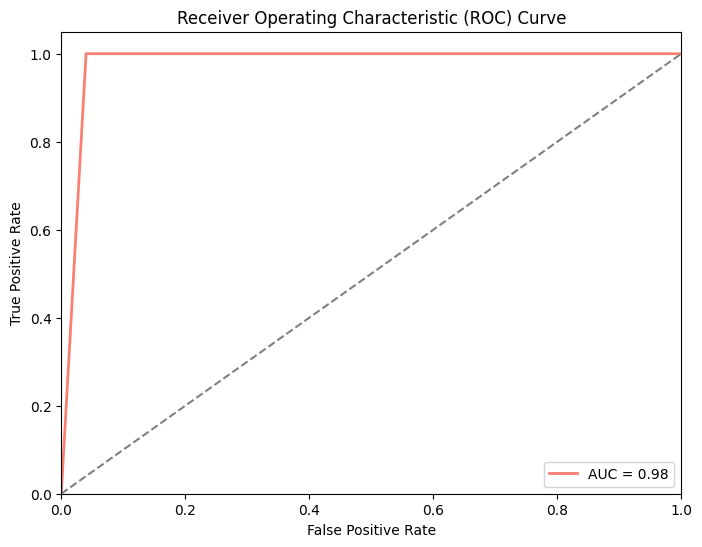

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
# Compute the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='salmon', lw=2, label=f'AUC = {roc_auc:.2f}')  # Plot TPR vs. FPR with AUC in the legend
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Plot the diagonal reference line (random classifier)
plt.xlim([0.0, 1.0])    # Set x-axis limits
plt.ylim([0.0, 1.05])   # Set y-axis limits
plt.xlabel('False Positive Rate')  # Label for x-axis
plt.ylabel('True Positive Rate')   # Label for y-axis
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Title of the plot
plt.legend(loc="lower right")  # Display legend in the lower right corner
plt.show()  # Display the plot


**VIT Model**

In [ ]:
# 4. Vision Transformer (ViT) Model - Standard
class ViTModel_Normal(nn.Module):
    def __init__(self):
        super(ViTModel_Normal, self).__init__()
        self.model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=2)

    def forward(self, x):
        return self.model(x).logits

model_vit = ViTModel_Normal()  # Exemple avec ResNet-18
model_vit.load_state_dict(torch.load('vit_model.pth'))
model_vit.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel_Normal(
  (model): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (intermediate): ViTIntermediate(
              (dense): L

Accuracy: 0.8000
              precision    recall  f1-score   support

        Real       0.93      0.56      0.70        25
     Cartoon       0.76      0.97      0.85        35

    accuracy                           0.80        60
   macro avg       0.84      0.77      0.77        60
weighted avg       0.83      0.80      0.79        60



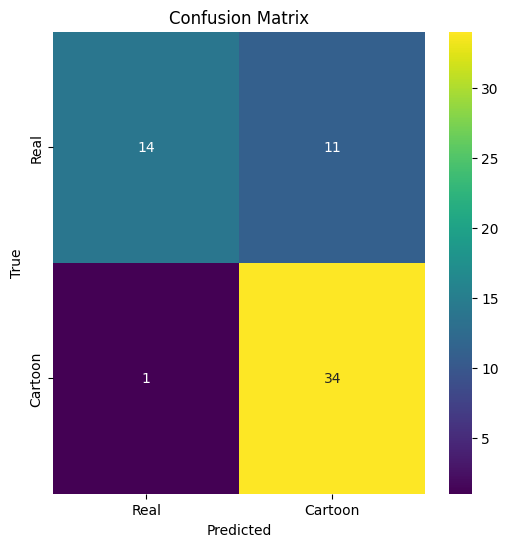

In [ ]:
# Initialize variables to store metrics
all_labels = []         # Will store all true labels
all_predictions = []    # Will store all predicted labels

# Evaluation loop
with torch.no_grad():  # Disable gradient calculation to save memory and computation during inference
    for images, labels in test_loader:
        outputs = model_vit(images)                   # Get model outputs for the input images
        _, predicted = torch.max(outputs, 1)          # Get the predicted class index with the highest score

        all_labels.extend(labels.cpu().numpy())           # Move true labels to CPU and convert to numpy
        all_predictions.extend(predicted.cpu().numpy())   # Move predicted labels to CPU and convert to numpy

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f'Accuracy: {accuracy:.4f}')  # Print accuracy rounded to 4 decimal places

# Generate classification report (includes precision, recall, and F1-score)
report = classification_report(all_labels, all_predictions, target_names=['Real', 'Cartoon'])
print(report)  # Display the report

# Display confusion matrix as a heatmap
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(6, 6))  # Set figure size
sns.heatmap(
    cm, annot=True, fmt='d', cmap='viridis',
    xticklabels=['Real', 'Cartoon'], yticklabels=['Real', 'Cartoon']
)  # Plot the confusion matrix
plt.xlabel('Predicted')     # Label for x-axis
plt.ylabel('True')          # Label for y-axis
plt.title('Confusion Matrix')  # Title of the plot
plt.show()  # Show the plot


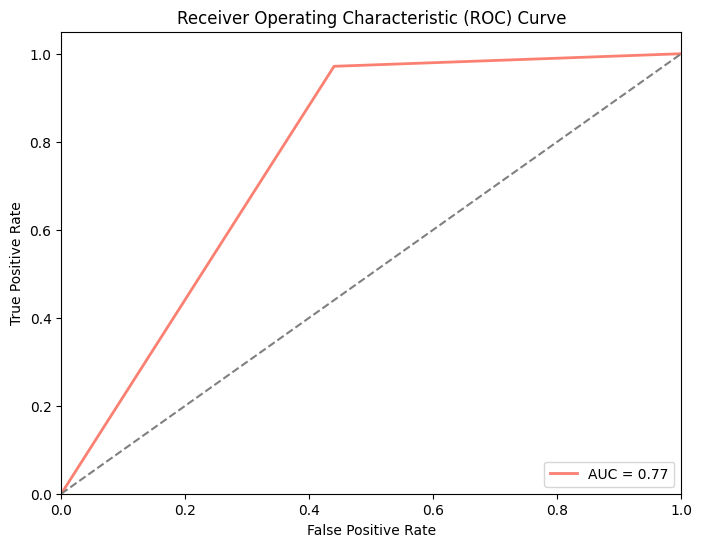

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
# Compute the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))  # Set the size of the plot
plt.plot(fpr, tpr, color='salmon', lw=2, label=f'AUC = {roc_auc:.2f}')  # Plot the ROC curve with AUC in the legend
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Plot the diagonal line for reference (random classifier)
plt.xlim([0.0, 1.0])  # Set x-axis limits
plt.ylim([0.0, 1.05]) # Set y-axis limits
plt.xlabel('False Positive Rate')  # Label for x-axis
plt.ylabel('True Positive Rate')   # Label for y-axis
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Title of the plot
plt.legend(loc="lower right")  # Display legend in the bottom-right corner
plt.show()  # Render the plot
